In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
import glob

from tqdm import tqdm
import seaborn as sns
from collections import Counter

import cv2

In [2]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

In [3]:
import cudf, cuml, cupy
from cuml.feature_extraction.text import TfidfVectorizer
from cuml.neighbors import NearestNeighbors

In [4]:
train = pd.read_csv("/kaggle/happywhale/input/train.csv")
train.shape

(51033, 3)

In [5]:
train.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)

In [6]:
FOLD=4

In [7]:
fold_lis = []
for i in range(len(train)):
    fold_lis.append(i%5)
    
train["fold"] = fold_lis

In [8]:
all_only_val_set = set()

for fold in range(5):
    tr = train[train.fold!=fold]
    val = train[train.fold==fold]

    train_id_set = set(tr.individual_id)
    val_id_set = set(val.individual_id)

    only_val_set = val_id_set- train_id_set

    for val_id in list(only_val_set):
        all_only_val_set.add(str(fold) +"_"+ val_id)

In [9]:
train_df = train[train.fold!=FOLD].copy()
valid_df = train[train.fold==FOLD].copy()

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [10]:
use_val_id_during_traing = []

for val_id in valid_df.individual_id.values:

    if str(FOLD) + "_" + val_id in all_only_val_set:
        use_val_id_during_traing.append(False)
    else:
        use_val_id_during_traing.append(True)


valid_df["use_in_train"] = use_val_id_during_traing

In [11]:
from collections import defaultdict
d = defaultdict(lambda: -1)
now=0

new_label_group = []

for i,row in train_df.iterrows():
    if d[row["individual_id"]]==-1:
        d[row["individual_id"]]=now
        now+=1
    
    new_label_group.append(d[row["individual_id"]])

In [12]:
train_df["new_individual_id"]  = new_label_group

In [13]:
valid_df_for_train = valid_df[valid_df.use_in_train].copy()
valid_df_for_train = valid_df_for_train.reset_index(drop=True)

In [14]:
new_individual_id_lis = []


for val_id in valid_df_for_train.individual_id.values:
    new_individual_id_lis.append(d[val_id])

In [15]:
valid_df_for_train["new_individual_id"] = new_individual_id_lis

In [16]:
from sklearn.preprocessing import normalize
from scipy.spatial import distance

In [17]:
import pickle

def load_emb(exp_names,pickle_name):
    # train/valid   train_all/test
    emb_lis = []
    for exp in exp_names:
        
        dirname = "/kaggle/happywhale/working/" + exp
        
        with open(dirname + '/' + pickle_name + '.pickle', 'rb') as f:
            valid_preds = pickle.load(f)
        emb_lis.append(valid_preds)
        print(valid_preds.shape)
    
    return normalize(np.concatenate(emb_lis,axis=1))
        

In [18]:
exps = ["exp113"]

In [19]:
assert len(exps) == len(set(exps))

In [20]:
test_df =pd.read_csv("../input/sample_submission.csv")
test_df.shape

(27956, 2)

### predict nearest species for each test

In [21]:
test_preds      = load_emb(exps,"test")
train_all_preds = load_emb(exps,"train_all")

(27956, 512)
(51033, 512)


In [22]:
from sklearn.metrics import pairwise_distances

In [23]:
%%time

#distances = cuml.metrics.pairwise_distances(test_preds,train_all_preds)
distances =pairwise_distances(test_preds,train_all_preds)

CPU times: user 53.2 s, sys: 1min 16s, total: 2min 9s
Wall time: 18.4 s


In [24]:
%%time

K=1
predicted_positions = np.argpartition(distances, K, axis=1)[:, :K]

CPU times: user 4.59 s, sys: 5.73 s, total: 10.3 s
Wall time: 10.4 s


In [25]:
predicted_positions.shape

(27956, 1)

In [26]:
train_species_lis = train.species.values
test_pred_species = []


for i in range(len(predicted_positions)):
    train_species = train_species_lis[predicted_positions[i]][0]
    test_pred_species.append(train_species)

In [27]:
test_df["species"] = test_pred_species

In [28]:
test_df.head()

,image,predictions,species
0,000110707af0ba.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,gray_whale
1,0006287ec424cb.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,false_killer_whale
2,000809ecb2ccad.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,beluga
3,00098d1376dab2.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,humpback_whale
4,000b8d89c738bd.jpg,37c7aba965a5 114207cab555 a6e325d8e924 19fbb96...,dusky_dolphin


### normal prediction(without new_individual)

In [29]:
test_preds      = load_emb(exps,"test")
train_all_preds = load_emb(exps,"train_all")

(27956, 512)
(51033, 512)


In [30]:
test_preds.shape

(27956, 512)

In [31]:
train_all_preds.shape

(51033, 512)

In [32]:
%%time

#distances = cuml.metrics.pairwise_distances(test_preds,train_all_preds)
distances =pairwise_distances(test_preds,train_all_preds)

CPU times: user 55.7 s, sys: 1min 15s, total: 2min 11s
Wall time: 21.8 s


In [33]:
%%time

K=1000
predicted_positions = np.argpartition(distances, K, axis=1)[:, :K]

CPU times: user 15.5 s, sys: 8.88 s, total: 24.4 s
Wall time: 34 s


In [34]:
sub_pred_lis = []

train_inddividual_id_lis = train["individual_id"].values


for i in tqdm(range(predicted_positions.shape[0])):
    nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
    nearest.sort(key=lambda x: x[1])

    prediction = [index_id for index_id, d in nearest]
    
    done = set()
    pred_list = []
    for pred_id in prediction:
        if pred_id in done:
            continue
        done.add(pred_id)
        pred_list.append(pred_id)
        if len(pred_list)==5:
            break    

            
    sub_pred_lis.append(pred_list)

100%|██████████| 27956/27956 [00:30<00:00, 915.28it/s] 


In [35]:
pred_lis_joined = []
for preds in sub_pred_lis:
    pred_lis_joined.append(" ".join(preds))

In [36]:
test_df["predictions"] = pred_lis_joined

In [37]:
test_df

,image,predictions,species
0,000110707af0ba.jpg,fbe2b15b5481 836708f5e690 5a199d197c45 7e7ee27...,gray_whale
1,0006287ec424cb.jpg,1424c7fec826 e72a5024c4ad 8870c00f2eda 5325e39...,false_killer_whale
2,000809ecb2ccad.jpg,1ce3ba6a3c29 9c011e5bbf3b 9e788f1982d6 9a41dd5...,beluga
3,00098d1376dab2.jpg,c4274d90be60 27be93c53673 6a6fa3ec3810 69c3563...,humpback_whale
4,000b8d89c738bd.jpg,cf500d3874bc c88cb1224033 ebd4f2c3e8d1 d4d2cd4...,dusky_dolphin
...,...,...,...
27951,fff6ff1989b5cd.jpg,734573d54bef ec0aa394b7e5 33f637e7d02c 79d85d2...,spinner_dolphin
27952,fff8fd932b42cb.jpg,129a9e2703f0 34ae492ed158 d3ddb92fb6ea 42d32d5...,dusky_dolphin
27953,fff96371332c16.jpg,2fad3a13934d d322fe55b12e 8dc43144e9cb ed8e5aa...,beluga
27954,fffc1c4d3eabc7.jpg,a8fe10f7b3e0 3c06337d5955 3295906b0cc8 f9a293d...,cuviers_beaked_whale


In [38]:
test_df.to_csv("submission_" +"_".join(exps)+ ".csv",index=None)

### add new_individual by fixed threshold 

In [39]:
new_individual_thr=1.0

In [40]:
sub_pred_lis = []

train_inddividual_id_lis = train["individual_id"].values
new_ind_1_cnt=0

for i in tqdm(range(predicted_positions.shape[0])):
    nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
    
    nearest.sort(key=lambda x: x[1])

    done = set()
    pred_list = []
    for pred_id, score in nearest:
        if score > new_individual_thr and not "new_individual" in done:
            pred_list.append("new_individual")
            done.add("new_individual")
            
        if pred_id in done:
            continue
        done.add(pred_id)
        pred_list.append(pred_id)
        if len(pred_list)>=5:
            break    

    if pred_list[0]=="new_individual":
        new_ind_1_cnt+=1
    sub_pred_lis.append(pred_list[:5])

100%|██████████| 27956/27956 [00:30<00:00, 918.63it/s]


In [41]:
new_ind_1_cnt/len(test_df)

0.3029045643153527

In [42]:
pred_lis_joined = []
for preds in sub_pred_lis:
    pred_lis_joined.append(" ".join(preds))

In [43]:
test_df["predictions"] = pred_lis_joined

In [44]:
test_df

,image,predictions,species
0,000110707af0ba.jpg,fbe2b15b5481 836708f5e690 new_individual 5a199...,gray_whale
1,0006287ec424cb.jpg,1424c7fec826 new_individual e72a5024c4ad 8870c...,false_killer_whale
2,000809ecb2ccad.jpg,1ce3ba6a3c29 new_individual 9c011e5bbf3b 9e788...,beluga
3,00098d1376dab2.jpg,c4274d90be60 27be93c53673 new_individual 6a6fa...,humpback_whale
4,000b8d89c738bd.jpg,cf500d3874bc new_individual c88cb1224033 ebd4f...,dusky_dolphin
...,...,...,...
27951,fff6ff1989b5cd.jpg,734573d54bef new_individual ec0aa394b7e5 33f63...,spinner_dolphin
27952,fff8fd932b42cb.jpg,new_individual 129a9e2703f0 34ae492ed158 d3ddb...,dusky_dolphin
27953,fff96371332c16.jpg,new_individual 2fad3a13934d d322fe55b12e 8dc43...,beluga
27954,fffc1c4d3eabc7.jpg,new_individual a8fe10f7b3e0 3c06337d5955 32959...,cuviers_beaked_whale


In [45]:
test_df.to_csv("submission_" +str(new_individual_thr)+".csv",index=None)

### set new_individual threshold

In [46]:
test_new_ind_cnt_df = pd.read_csv("../input/test_new_ind_ratio_0402.csv")

In [47]:
test_new_ind_cnt_df

,species,test_new_ind_ratio
0,humpback_whale,0.097941
1,bottlenose_dolphin,0.025106
2,beluga,0.006468
3,dusky_dolphin,0.523474
4,false_killer_whale,0.015609
5,killer_whale,0.017829
6,spinner_dolphin,0.064464
7,blue_whale,0.048034
8,melon_headed_whale,0.376427
9,fin_whale,0.101046


In [48]:
# Multiply test_new_ind_ratio by "multiplier"
# e.g. beluga's test_new_ind_ratio is 0.006468, 
# if multiplier = 2.0, set threshold for beluga 0.006468*2=0.012936
# if multiplier = 0.5, set threshold for beluga 0.006468/2=0.003234

# we have to find best multiplier for LB
# (again, it must be overfit to LB)

def get_thr(spe,ratio_target_df,top1=True,multiplier=1.0):
    spe_ind_lis = test_df.query("species == @spe").index.values
    sub_pred_lis=[]
    
    for i in spe_ind_lis:
        nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
        nearest.sort(key=lambda x: x[1])

        prediction = [index_id for index_id, d in nearest]
        dists = [d for index_id, d in nearest]

        done = set()
        dist_list = []
        for pred_id,dist in zip(prediction,dists):
            if pred_id in done:
                continue
            done.add(pred_id)
            dist_list.append(dist)
            if len(dist_list)==5:
                break    


        sub_pred_lis.append(dist_list)
    
    ratio_target = multiplier * ratio_target_df.query("species == @spe").iloc[0]["test_new_ind_ratio"]
    
    return binary(sub_pred_lis,ratio_target,top1)

In [49]:
# binary search methods

def solve(sub_pred_lis,mid,target_ratio):
    ratio_lis = []
    for i in range(len(sub_pred_lis)):
        ratio = 0
        for j in range(5):
            if sub_pred_lis[i][j] > mid: # j is new_ind
                ratio = 1/(j+1)
                break
        
        ratio_lis.append(ratio)
    return np.mean(ratio_lis) < target_ratio

def solve_top1(sub_pred_lis,mid,target_ratio):
    ratio_lis = []
    for i in range(len(sub_pred_lis)):
        ratio = 0
        for j in range(5):
            if sub_pred_lis[i][0] > mid: 
                ratio = 1
                break
        
        ratio_lis.append(ratio)
    return np.mean(ratio_lis) < target_ratio

def binary(sub_pred_lis,target_ratio,top1):
    ok=2
    ng=0
    cnt=0
    while cnt<100:
        cnt+=1
        mid = (ok+ng)/2
        #ret = solve(sub_pred_lis,mid,target_ratio)
        if top1:
            ret = solve_top1(sub_pred_lis,mid,target_ratio)
        else:
            ret = solve(sub_pred_lis,mid,target_ratio)
            
        if ret:
            ok=mid
        else:
            ng=mid
    return ok

In [50]:
# if we set beluga's threshold 1.14, we can expect beluga has 0.003234 new_individual
get_thr("beluga",test_new_ind_cnt_df,top1=True,multiplier=0.5)

1.140183448791504

In [51]:
get_thr("beluga",test_new_ind_cnt_df,top1=True,multiplier=1.0)

1.1302247047424316

In [52]:
get_thr("beluga",test_new_ind_cnt_df,top1=True,multiplier=1.5)

1.1199551820755005

In [53]:
get_thr("dusky_dolphin",test_new_ind_cnt_df,top1=True)

1.0311923027038574

In [54]:
spe_lis = test_new_ind_cnt_df.species.values

### Add new_individual by new_ind_ratio

In [55]:
MULTIPLIER=1.3

In [56]:
thr_lis_top1 = []
for spe in tqdm(spe_lis):
    thr = get_thr(spe,test_new_ind_cnt_df,top1=True,multiplier=MULTIPLIER)
    thr_lis_top1.append(thr)

100%|██████████| 26/26 [00:52<00:00,  2.02s/it]


In [57]:
thr_df = pd.DataFrame()
thr_df["species"] = spe_lis
thr_df["thr"] = thr_lis_top1

In [58]:
thr_df

,species,thr
0,humpback_whale,1.098942
1,bottlenose_dolphin,1.084660
2,beluga,1.123397
3,dusky_dolphin,0.953195
4,false_killer_whale,1.098881
5,killer_whale,1.099415
6,spinner_dolphin,1.095389
7,blue_whale,1.117441
8,melon_headed_whale,0.985881
9,fin_whale,1.061359


In [59]:
sub_pred_lis = []

train_inddividual_id_lis = train["individual_id"].values
new_ind_1_cnt=0

new_ind_index_lis = [] # 1, 0.5 ,0.33, 0.25, 0.2

for i in tqdm(range(predicted_positions.shape[0])):
    nearest = [(train_inddividual_id_lis[j], distances[i, j]) for j in predicted_positions[i]]
    
    nearest.sort(key=lambda x: x[1])
    
    spe = test_pred_species[i]
    new_individual_thr = thr_df.query("species == @spe").iloc[0].thr

    done = set()
    pred_list = []
    new_ind_ind = 0
    for pred_id, score in nearest:
        if score > new_individual_thr and not "new_individual" in done:
            pred_list.append("new_individual")
            done.add("new_individual")
            new_ind_index_lis.append(1/len(pred_list))
            
        if pred_id in done:
            continue
        done.add(pred_id)
        pred_list.append(pred_id)
        if len(pred_list)>=5:
            break    

    if pred_list[0]=="new_individual":
        new_ind_1_cnt+=1
    sub_pred_lis.append(pred_list[:5])

100%|██████████| 27956/27956 [01:06<00:00, 418.35it/s]


In [60]:
new_ind_1_cnt/len(test_df)

0.14097152668479038

In [61]:
np.mean(new_ind_index_lis)

0.48062190660641274

In [62]:
pred_lis_joined = []
for preds in sub_pred_lis:
    pred_lis_joined.append(" ".join(preds))

In [63]:
test_df["predictions"] = pred_lis_joined

In [64]:
test_df[["image","predictions"]].to_csv("submission_multi_" +str(MULTIPLIER)+".csv",index=None)

In [65]:
test_df

,image,predictions,species
0,000110707af0ba.jpg,fbe2b15b5481 836708f5e690 new_individual 5a199...,gray_whale
1,0006287ec424cb.jpg,1424c7fec826 e72a5024c4ad new_individual 8870c...,false_killer_whale
2,000809ecb2ccad.jpg,1ce3ba6a3c29 9c011e5bbf3b 9e788f1982d6 9a41dd5...,beluga
3,00098d1376dab2.jpg,c4274d90be60 27be93c53673 new_individual 6a6fa...,humpback_whale
4,000b8d89c738bd.jpg,cf500d3874bc new_individual c88cb1224033 ebd4f...,dusky_dolphin
...,...,...,...
27951,fff6ff1989b5cd.jpg,734573d54bef ec0aa394b7e5 new_individual 33f63...,spinner_dolphin
27952,fff8fd932b42cb.jpg,new_individual 129a9e2703f0 34ae492ed158 d3ddb...,dusky_dolphin
27953,fff96371332c16.jpg,2fad3a13934d d322fe55b12e 8dc43144e9cb ed8e5aa...,beluga
27954,fffc1c4d3eabc7.jpg,new_individual a8fe10f7b3e0 3c06337d5955 32959...,cuviers_beaked_whale


check result

In [66]:
top1_new_ind_spe = defaultdict(list)
new_ind_score_spe = defaultdict(list)

for i in range(len(test_pred_species)):
    spe = test_pred_species[i]
    
    if sub_pred_lis[i][0] == "new_individual":
        top1_new_ind_spe[spe].append(1)
    else:
        top1_new_ind_spe[spe].append(0)
        
    if "new_individual" in sub_pred_lis[i]:
        ind = sub_pred_lis[i].index("new_individual")
        new_ind_score_spe[spe].append(1/(ind+1))
    else:
        new_ind_score_spe[spe].append(0)

In [67]:
spe_lis = []
top1_lis = []
cnt_lis = []
ratio_lis = []

all_sum = 0
for k,v in top1_new_ind_spe.items():
    spe_lis.append(k)
    
    cnt = len(v)
    sum1 = np.sum(v)
    top1_lis.append(sum1/cnt)
    cnt_lis.append(cnt)
    
    ratios = new_ind_score_spe[k]
    ratio_lis.append(np.mean(ratios))

In [68]:
df = pd.DataFrame()

In [69]:
df["species"] = spe_lis
df["top1"] = top1_lis
df["ratio"] = ratio_lis
df["cnt"] = cnt_lis

multiplier is 1.3  
beluga has 0.006468 * 1.3 = 0.0084084 top_1 ratio

In [70]:

df.query("cnt > 100").sort_values("cnt")


,species,top1,ratio,cnt
21,white_sided_dolphin,0.241611,0.559508,149
13,long_finned_pilot_whale,0.125654,0.535340,191
17,common_dolphin,0.128079,0.420279,203
14,sei_whale,0.127586,0.443448,290
19,spotted_dolphin,0.302326,0.605669,344
7,cuviers_beaked_whale,0.485175,0.712084,371
18,minke_whale,0.330935,0.609502,556
0,gray_whale,0.063665,0.222697,644
8,southern_right_whale,0.109256,0.311052,659
20,short_finned_pilot_whale,0.043970,0.342525,796


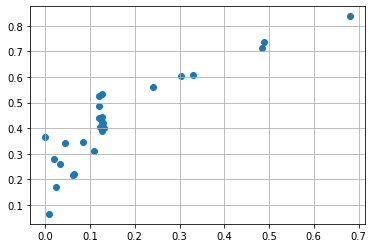

In [71]:
plt.scatter(df.top1,df.ratio)
plt.grid()